In [1]:
import json

with open("../raw/label_descriptions.json") as f:
    meta = json.load(f)
    
meta.keys()

dict_keys(['info', 'categories', 'attributes'])

In [2]:
df_ctg = pd.DataFrame(meta["categories"]).set_index("id")
df_ctg = df_ctg[~df_ctg["supercategory"].isin(["garment parts", "closures", "decorations"])]
df_ctg

,name,supercategory,level
id,,,
0,"shirt, blouse",upperbody,2
1,"top, t-shirt, sweatshirt",upperbody,2
2,sweater,upperbody,2
3,cardigan,upperbody,2
4,jacket,upperbody,2
5,vest,upperbody,2
6,pants,lowerbody,2
7,shorts,lowerbody,2
8,skirt,lowerbody,2


In [3]:
df_attr = pd.DataFrame(meta["attributes"]).set_index("id")
df_attr

,name,supercategory,level
id,,,
0,above-the-hip (length),length,1
1,hip (length),length,1
2,micro (length),length,1
3,mini (length),length,1
4,above-the-knee (length),length,1
...,...,...,...
87,high waist,waistline,1
88,normal waist,waistline,1
89,low waist,waistline,1


In [4]:
df = pd.read_csv("../raw/train.csv")
df["category_id"] = df["ClassId"].apply(lambda c: c.split("_")[0]).astype("int32")
df = df[df["category_id"].isin(df_ctg.index)]
df

,ImageId,EncodedPixels,Height,Width,ClassId,category_id
0,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,6068157 7 6073371 20 6078584 34 6083797 48 608...,5214,3676,6,6
1,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,6323163 11 6328356 32 6333549 53 6338742 75 63...,5214,3676,0,0
8,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,4566382 8 4571592 25 4576803 41 4582013 58 458...,5214,3676,4,4
10,0000fe7c9191fba733c8a69cfaf962b7.jpg,1343707 9 1346138 27 1348569 44 1351000 62 135...,2448,2448,1,1
12,0002ec21ddb8477e98b2cbb87ea2e269.jpg,2287509 4 2290504 12 2290588 26 2293501 18 229...,3000,1997,10,10
...,...,...,...,...,...,...
331202,fffe20b555b98c3c1f26c8dfff275cbc.jpg,3800472 4 3803465 12 3806458 20 3809451 29 381...,3000,2001,23,23
331203,fffe20b555b98c3c1f26c8dfff275cbc.jpg,2915555 2 2918553 4 2921550 7 2924547 9 292754...,3000,2001,23,23
331205,fffe20b555b98c3c1f26c8dfff275cbc.jpg,2611656 2 2614657 4 2617657 8 2620658 11 26236...,3000,2001,6,6
331207,fffe20b555b98c3c1f26c8dfff275cbc.jpg,2446541 2 2449539 5 2452536 10 2455534 14 2458...,3000,2001,0,0


In [5]:
# c.f., https://www.kaggle.com/c/imaterialist-fashion-2019-FGVC6/overview/evaluation
# ClassId: {category_id}_{attribute_id1}_{attribute_id2}_...

df_multi = df[df["ClassId"].apply(len) >= 3]
df_multi["ClassId"]

42           10_3_20_34_56_69_91
44         3_1_10_20_41_60_61_91
48        10_5_19_33_59_61_66_88
92            4_0_20_41_60_72_88
97               6_8_20_39_60_70
                   ...          
331136           8_3_20_33_60_61
331137     3_6_11_19_40_60_61_88
331163           1_0_20_41_49_61
331165     6_8_15_20_40_60_61_87
331166     9_3_10_20_41_60_61_91
Name: ClassId, Length: 11496, dtype: object

In [7]:
row = df_multi.iloc[0]
row

ImageId                       000aac3870ea7c59ca0333ffa5327323.jpg
EncodedPixels    8971124 17 8975101 49 8979077 82 8983053 116 8...
Height                                                        4000
Width                                                         6000
ClassId                                        10_3_20_34_56_69_91
category_id                                                     10
Name: 42, dtype: object

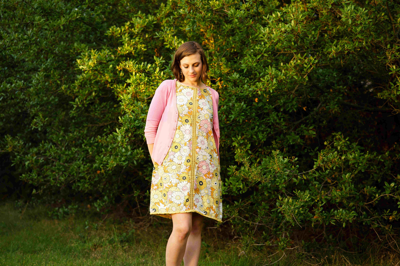

In [8]:
from PIL import Image

pil_img = Image.open(Path("../raw/train") / row["ImageId"]).convert("RGB")
pil_img.resize(
    (int(pil_img.size[0] / 15),
    int(pil_img.size[1] / 15))
)

In [31]:
from imaterialist.transforms import rle_to_mask

g = df[df["ImageId"] == row["ImageId"]]

masks = np.stack(
    g.apply(
        lambda r: rle_to_mask(r["EncodedPixels"], r["Height"], r["Width"]),
        axis=1,
    ),
    axis=-1
)
np.unique(masks)
masks.shape

category_ids = g["category_id"].values

from segmentation.transforms import masks_to_segmap

segmap = masks_to_segmap(masks, category_ids)
np.unique(segmap)
segmap.shape

array([0, 1], dtype=uint8)

(4000, 6000, 2)

array([  3,  10, 255], dtype=uint8)

(4000, 6000)

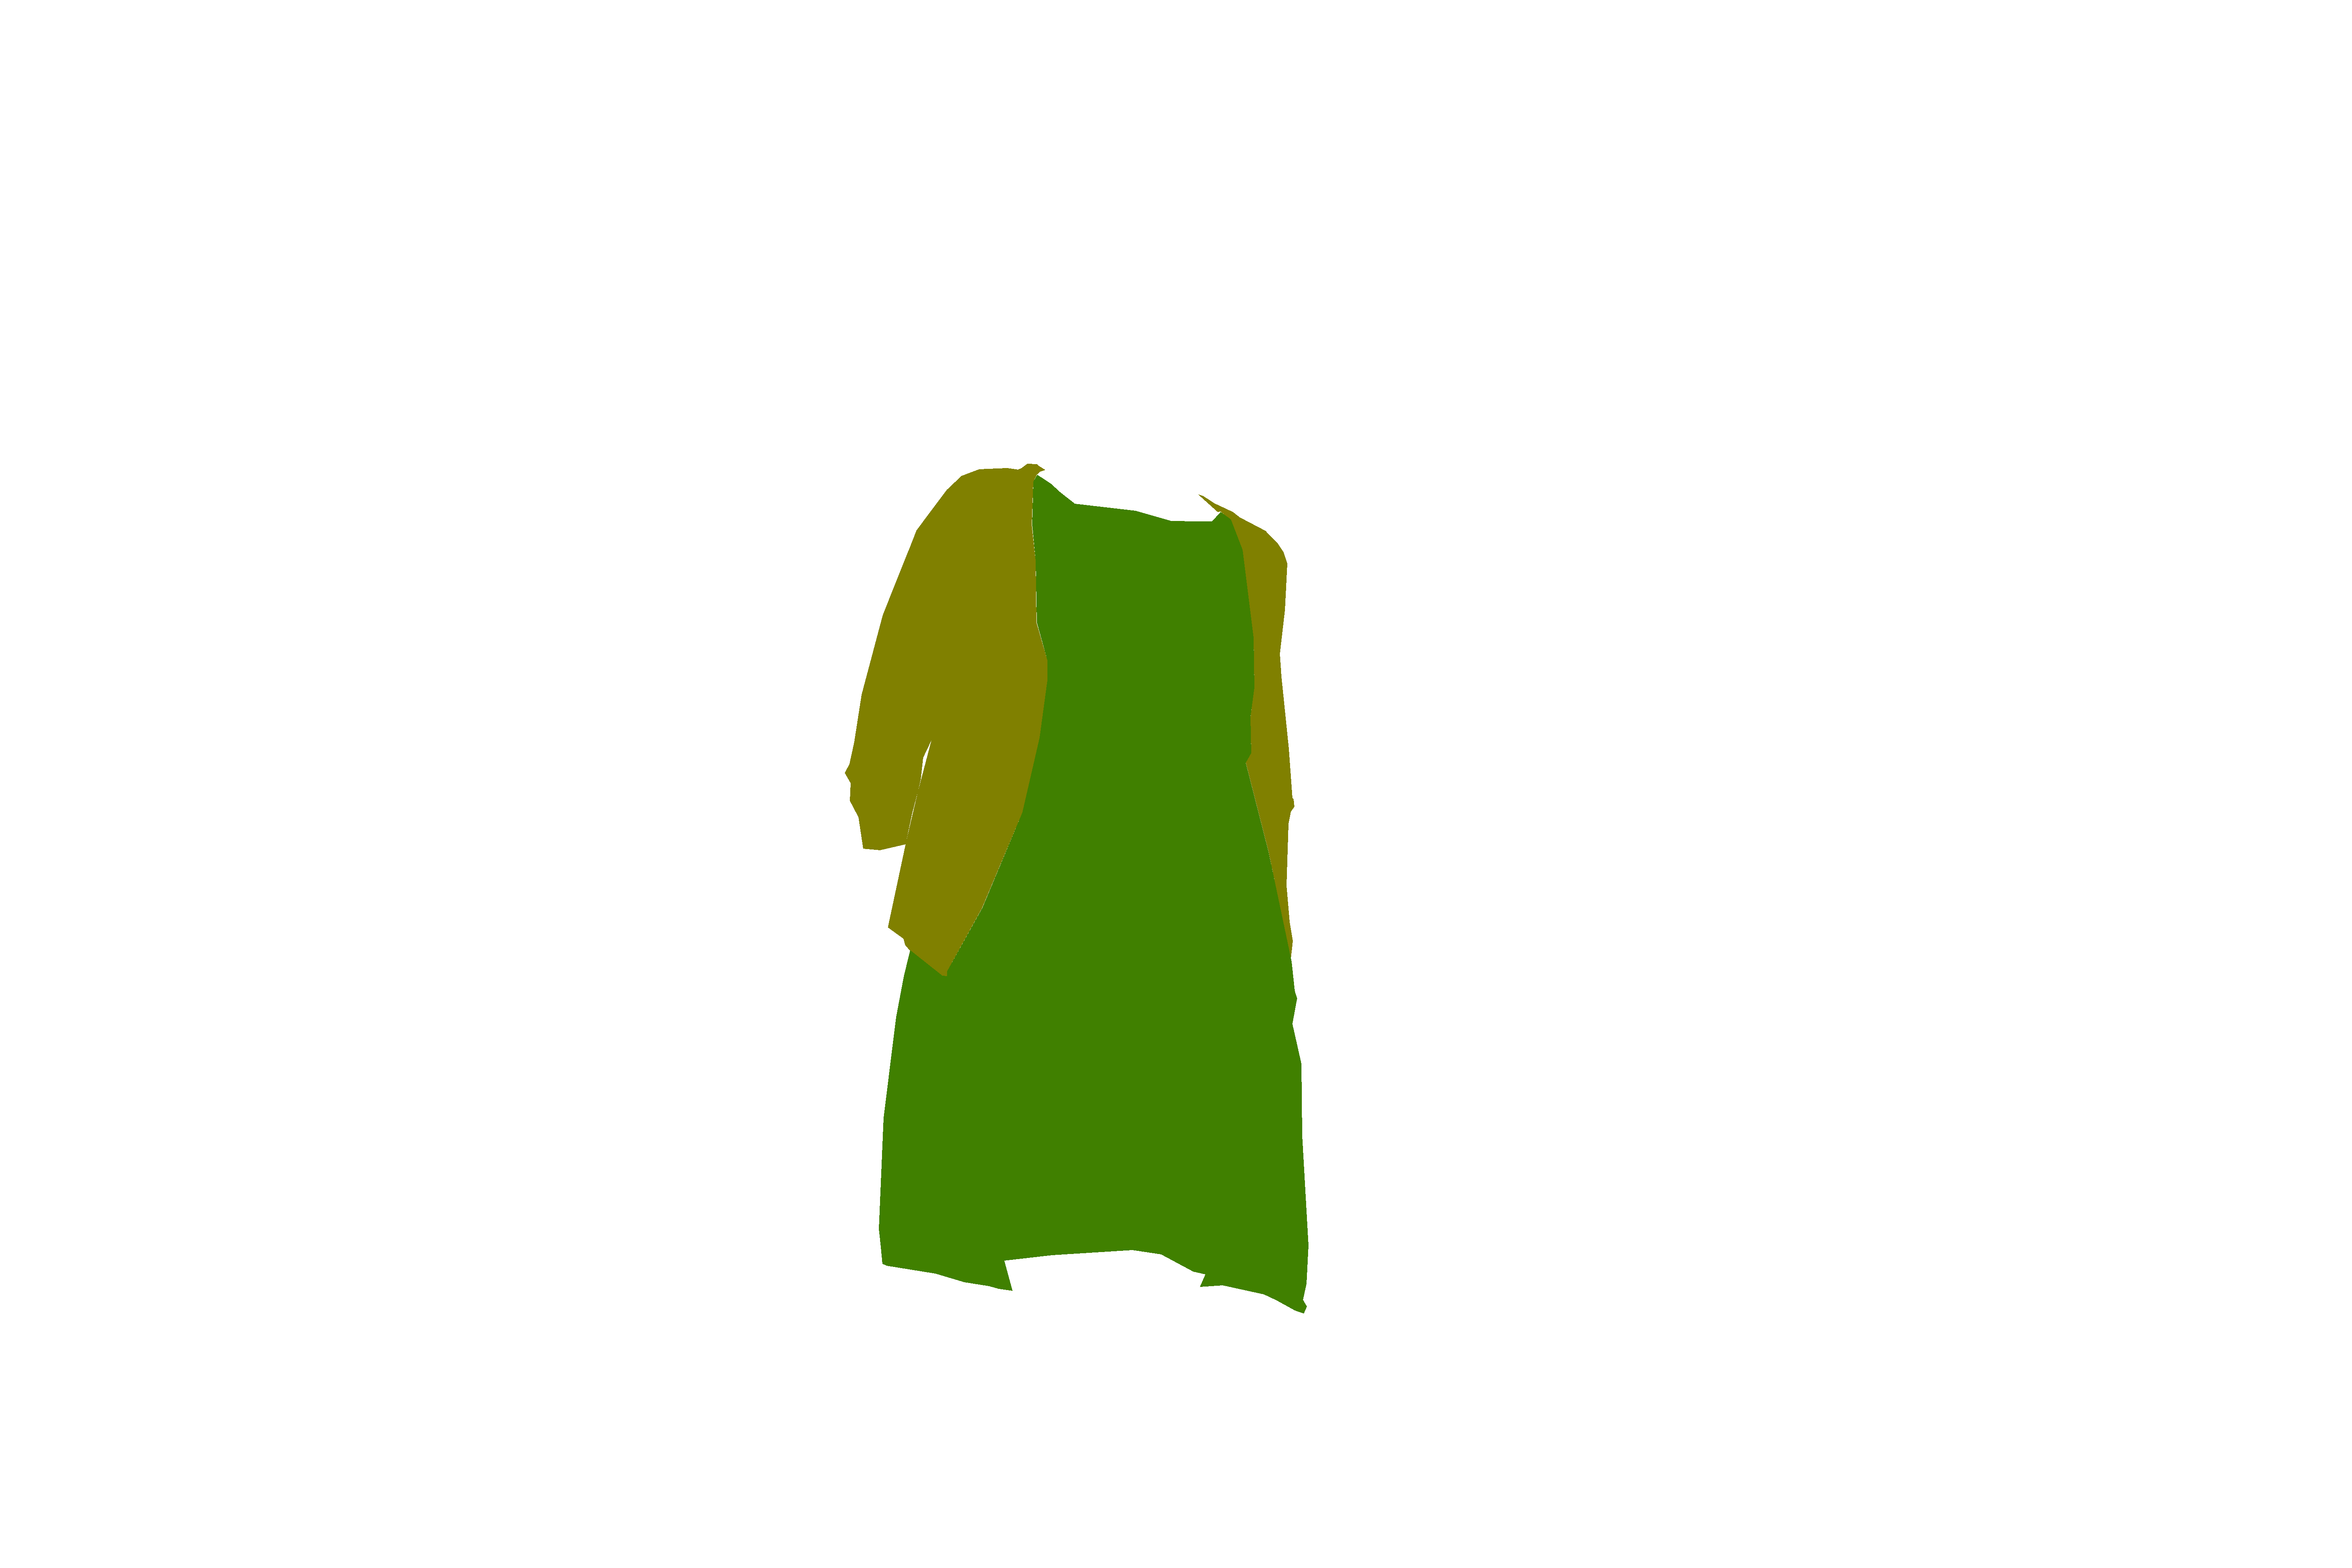

In [32]:
from segmentation.transforms import segmap_to_pil

pil_segmap = segmap_to_pil(segmap, df_ctg.index)
pil_segmap
pil_segmap.save("/tmp/segmap.png")

In [33]:
segmap = np.array(Image.open("/tmp/segmap.png"))
np.unique(segmap)
segmap.shape

array([  3,  10, 255], dtype=uint8)

(4000, 6000)

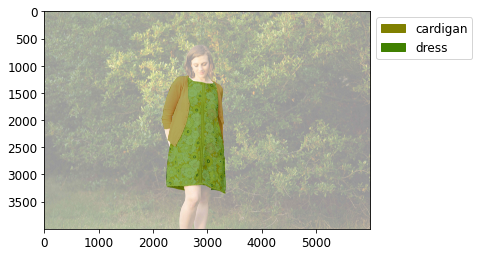

In [28]:
from segmentation.visualizations import vis_segmap


ax, legend_handles = vis_segmap(
    np.array(pil_img),
    segmap,
    label_names=df_ctg["name"].tolist(),
#     all_label_names_in_legend=True,
    alpha=0.6,
)
_ = ax.legend(handles=legend_handles, bbox_to_anchor=(1, 1), loc=2)

In [29]:
df_attr.iloc[[int(x) for x in row["ClassId"].split("_")[1:]]]

,name,supercategory,level
id,,,
3,mini (length),length,1
20,symmetrical,silhouette,1
34,a-line,silhouette,1
56,cutout,"textile finishing, manufacturing techniques",1
69,floral,textile pattern,1
91,no waistline,waistline,1


In [30]:
df[["Height", "Width"]].value_counts()

Height  Width
3000    2000     8812
1500    1000     4956
1024    683      4640
1000    667      4594
1200    800      3819
                 ... 
4220    2804        1
920     631         1
2722    2722        1
919     613         1
2581    3442        1
Length: 10730, dtype: int64